## Causal analysis of COVID-19 transmission in the United States

In [1]:
%matplotlib inline
import os
import requests
import urllib 

import pandas as pd
import numpy as np
import statsmodels.api as sm
import pymc3 as pm
import scipy

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import linear_model
from scipy import stats as sps
from sklearn.feature_selection import SelectFromModel
from IPython.display import display
from scipy.stats import gamma
from scipy.stats import invgamma
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import halfnorm
import random
import math

## 1. Data preprocessing

### 1.1 Import covariates and outcome data

In [2]:
covid_cases = pd.read_csv('/Users/likehang/Desktop/Thesis/data/covid_19_t.csv', parse_dates =["day"])
icu = pd.read_csv('/Users/likehang/Desktop/Thesis/data/icu_bed.csv')
mask = pd.read_csv('/Users/likehang/Desktop/Thesis/data/mask_use.csv')
trip_distance = pd.read_csv('/Users/likehang/Desktop/Trips_by_Distance.csv')
mobility = pd.read_csv('/Users/likehang/Desktop/Thesis/data/2020_US_Region_Mobility_Report.csv')
age_group = pd.read_excel("/Users/likehang/Desktop/Thesis/data/age_group.xlsx")

### 1. 2 Preprocessing for behavioral variables

#### 1.2.1 Trips in distances

In [3]:
trip_distance['Level'] = trip_distance['Level'].astype('str')
trip_distance_1 = trip_distance['Level'] == 'County'
trip_distance = trip_distance.loc[trip_distance_1]
trip_distance = trip_distance[(trip_distance['Date'] > '2020/01/18') & (trip_distance['Date'] < '2020/08/21')]

In [4]:
trip_distance["Number of Trips 1-10"] = trip_distance.loc[:,["Number of Trips <1","Number of Trips 1-3","Number of Trips 3-5","Number of Trips 5-10"]].sum(axis=1)
    
trip_distance["Number of Trips 10-100"] = trip_distance.loc[:,["Number of Trips 10-25","Number of Trips 25-50", "Number of Trips 50-100"]].sum(axis=1)

trip_distance["Number of Trips >100"] = trip_distance.loc[:,["Number of Trips 100-250","Number of Trips 250-500", "Number of Trips >=500"]].sum(axis=1)

trip_distance.drop(trip_distance.columns.difference(['Date','State FIPS','Population Not Staying at Home', 'Number of Trips 1-10','Number of Trips 10-100','Number of Trips >100']), 1, inplace=True)

In [5]:
trips = trip_distance.groupby(['Date', 'State FIPS']).agg({ 'Number of Trips 1-10':'sum',
                                                    'Number of Trips 10-100':'sum',
                                                    'Number of Trips >100':'sum',
                                                    'Population Not Staying at Home':'sum'})

trips = pd.DataFrame(trips).reset_index()

trips.to_csv("/Users/likehang/Desktop/trips_distance_cleaned.csv")

#### 1.2.2 Mask use 

In [6]:
mask['COUNTYFP'] = mask['COUNTYFP'].astype(str)
mask['COUNTYFP'] = mask['COUNTYFP'].apply(lambda x: x.zfill(5))
mask['State'] = mask.COUNTYFP.astype(str).str[:2]

In [7]:
mask = mask.groupby('State').mean().reset_index()
mask.to_csv("/Users/likehang/Desktop/mask_use_cleaned.csv")

#### 1.2.3 Mobility report

In [8]:
mobility = mobility[mobility.iso_3166_2_code.notnull()]
mobility.drop(['country_region_code', 'country_region','sub_region_2','metro_area','census_fips_code'], axis=1, inplace=True)
mobility = mobility[(mobility['date'] > '2020-01-18') & (mobility['date'] < '2020-08-21')]
mobility.to_csv("/Users/likehang/Desktop/mobility_cleaned.csv")

### 1.3 Preprocessing for demographics variables

#### 1.3.1 ICU beds number

In [9]:
icu = icu.groupby('State',as_index=False).agg({'ICU_beds':'mean'}).rename({'ICU_beds':'ICU_beds'},axis=1)
icu.to_csv("/Users/likehang/Desktop/icu_beds_cleaned.csv")

#### 1.3.2 Age groups

In [10]:
age_group['n_1'] = age_group.loc[:,["0_9","10_19","20_29","30_39","40_49","50_59","60_69","70_79","80_100"]].sum(axis=1)

age_group['n_2'] = age_group.loc[:,["60_69","70_79","80_100"]].sum(axis=1)

age_group['prop over 60'] = age_group['n_2'] / age_group['n_1']

In [11]:
age_group.to_csv("/Users/likehang/Desktop/age_group_cleaned.csv")

#### 1.3.3 Policy response index

In [12]:
policy = pd.read_csv("https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv").reset_index()

/Users/likehang/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [13]:
policy = pd.DataFrame(policy)
policy['CountryName'] = policy['CountryName'].str.strip()
policy = policy.loc[policy['CountryName'] == 'United States']

In [14]:
policy = policy[policy.RegionName.notnull()]
policy = policy[(policy['Date'] > 20200118) & (policy['Date'] < 20200821)]
policy.to_csv("/Users/likehang/Desktop/policy_index_cleaned.csv")

In [15]:
policy.to_csv("/Users/likehang/Desktop/policy_index_cleaned.csv")

### 1.4 Python crawler to extract COVID 19 Google trends data

In [16]:
import crawler_google as crawler
from pytrends.request import TrendReq

In [17]:
google_data = crawler.google('Covid',100)
for keyword in ['Coronavirus', 'Hand Sanitizer', 'Lockdown', 'Masker', 'disinfecting', 'takeout', 'movie ticket', 'restaurant', 'dining out', 'food delivery','flight','train', 'uber', 'stay at home','work from home', 'Pandemic','Social Distancing', 'Vaccine', 'Zoom', 'home schooling','clorox','quarantine','grocery']:
    data2 = crawler.google(keyword,100)
    google_data = google_data.merge(data2) 

In [18]:
google_data.to_csv("/Users/likehang/Desktop/google_trend_cleaned.csv")

In [19]:
google_data.head()

,time,Covid,Coronavirus,Hand Sanitizer,Lockdown,Masker,disinfecting,takeout,movie ticket,restaurant,...,stay at home,work from home,Pandemic,Social Distancing,Vaccine,Zoom,home schooling,clorox,quarantine,grocery
0,2020/01/18,0,0,1,0,17,2,18,71,75,...,1,15,0,0,9,5,11,5,0,36
1,2020/01/19,0,1,1,0,14,2,12,44,65,...,1,20,0,0,10,6,11,6,1,36
2,2020/01/20,0,2,1,0,15,2,13,45,60,...,1,20,1,0,12,6,8,5,1,27
3,2020/01/21,0,4,1,0,16,2,13,31,59,...,1,24,1,0,12,6,8,6,1,28
4,2020/01/22,0,5,1,1,13,2,11,41,63,...,1,20,2,0,13,6,12,7,2,26


In [3]:
def get_searches(key_word, state):
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload([key_word], cat=0, timeframe='2020-01-19 2020-08-21',  gprop='',geo='US-{}'.format(state))    
    df = pytrends.interest_over_time()

In [6]:
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload(['covid'], cat=0, timeframe='2020-01-19 2020-08-21',  gprop='', geo='US-NJ')
df = pytrends.interest_over_time()

### 1.5 Preview and reshape the covariates datasets

In [48]:
covid_cases = pd.read_csv('/Users/likehang/Desktop/Thesis/data/covid_19_t.csv')
icu = pd.read_csv('/Users/likehang/Desktop/icu_beds_cleaned.csv')
mask = pd.read_csv('/Users/likehang/Desktop/mask_use_cleaned.csv')
trip_distance = pd.read_csv('/Users/likehang/Desktop/trips_distance_cleaned.csv')
mobility = pd.read_csv('/Users/likehang/Desktop/mobility_cleaned.csv')
age_group = pd.read_csv("/Users/likehang/Desktop/age_group_cleaned.csv")
policy = pd.read_csv("/Users/likehang/Desktop/policy_index_cleaned.csv")
income = pd.read_csv("/Users/likehang/Desktop/US_income_2019.csv")
google = pd.read_csv("/Users/likehang/Desktop/google_trend_cleaned.csv")
trip_distance = trip_distance.sort_values(by=['State FIPS'])

#### 1.5.1 Make key columns State and Date consistent in value type

In [51]:
for data in [covid_cases, icu, mask, trip_distance, mobility, age_group, policy, income]:
    data['State'] = data['State'].astype(str)

In [52]:
for data in [covid_cases, trip_distance, mobility, policy]:
    data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d')

In [53]:
df = icu.merge(mask, on='State', how ='left')
df2 = mobility.merge(df, on='State' ,how = 'left')
df3 = df2.merge(trip_distance, on=['State','Date'] ,how = 'left')
df4 = df3.merge(age_group, on='State' ,how = 'left')
df5 = df4.merge(policy, on=['State','Date'] ,how = 'left')
df6 = df5.merge(income, on='State' ,how = 'left')
df7 = df6.merge(covid_cases, on=['State','Date'] ,how = 'left')
df7.to_csv("/Users/likehang/Desktop/data_cleaned.csv")

In [61]:
data = df7

In [150]:
data_01 = data.loc[data['State'] == 'Alabama']

In [151]:
data_01 = data_01.drop(columns=['State','State FIPS_y','State FIPS_x'])

cols = list(data_01.columns)
cols = [cols[-1]] + cols[:-1]
data_01 = data_01[cols]

data_01.to_csv("/Users/likehang/Desktop/data_01_cleaned.csv")

,State,Date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,ICU_beds,State FIPS_x,...,n_2,prop over 60,ConfirmedCases,ConfirmedDeaths,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,Annual income,Alabama
0,Alabama,2020-02-15,5.0,2.0,39.0,7.0,2,-1,9906.178571,1.0,...,1171184,0.238862,0.0,0.0,5.56,8.89,10.26,0.0,44145.0,0
1,Alabama,2020-02-16,0.0,-2.0,-7.0,3.0,-1,1,9906.178571,1.0,...,1171184,0.238862,0.0,0.0,5.56,8.89,10.26,0.0,44145.0,0
2,Alabama,2020-02-17,3.0,0.0,17.0,7.0,-17,4,9906.178571,1.0,...,1171184,0.238862,0.0,0.0,5.56,8.89,10.26,0.0,44145.0,0
3,Alabama,2020-02-18,-4.0,-3.0,-11.0,-1.0,1,2,9906.178571,1.0,...,1171184,0.238862,0.0,0.0,5.56,8.89,10.26,0.0,44145.0,0
4,Alabama,2020-02-19,4.0,1.0,6.0,4.0,1,0,9906.178571,1.0,...,1171184,0.238862,0.0,0.0,5.56,8.89,10.26,0.0,44145.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,Alabama,2020-08-16,-11.0,0.0,51.0,6.0,-17,3,9906.178571,1.0,...,1171184,0.238862,107667.0,1898.0,46.30,51.11,53.21,37.5,44145.0,110361
184,Alabama,2020-08-17,NaN,NaN,NaN,NaN,-29,6,9906.178571,1.0,...,1171184,0.238862,109092.0,1925.0,46.30,51.11,53.21,37.5,44145.0,111478
185,Alabama,2020-08-18,NaN,NaN,NaN,NaN,-27,7,9906.178571,1.0,...,1171184,0.238862,110415.0,1936.0,46.30,51.11,53.21,37.5,44145.0,112449
186,Alabama,2020-08-19,NaN,NaN,NaN,NaN,-29,6,9906.178571,1.0,...,1171184,0.238862,111696.0,1944.0,46.30,51.11,53.21,37.5,44145.0,113632


## 2. Analysis of Bayesian Structural Time Series 

In [66]:
from causalimpact import CausalImpact

In [222]:
data_01 = pd.read_csv("/Users/likehang/Desktop/data_01_cleaned.csv", index_col = False)
data_01 = data_01.set_index('Date')

In [203]:
data_01

,Alabama,retail,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,ICU_beds,NEVER,ALWAYS,...,Number of Trips >100,Population Not Staying at Home,20_29,prop over 60,ConfirmedDeaths,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex,Annual income
Date,,,,,,,,,,,,,,,,,,,,,
2020/2/15,0,5,2,39,7,2,-1,9906.178571,0.081567,0.475313,...,240285,4042364,660230,0.238862,0,5.56,8.89,10.26,0.0,44145
2020/2/16,0,0,-2,-7,3,-1,1,9906.178571,0.081567,0.475313,...,242758,3917865,660230,0.238862,0,5.56,8.89,10.26,0.0,44145
2020/2/17,0,3,0,17,7,-17,4,9906.178571,0.081567,0.475313,...,211760,3825630,660230,0.238862,0,5.56,8.89,10.26,0.0,44145
2020/2/18,0,-4,-3,-11,-1,1,2,9906.178571,0.081567,0.475313,...,239611,4101268,660230,0.238862,0,5.56,8.89,10.26,0.0,44145
2020/2/19,0,4,1,6,4,1,0,9906.178571,0.081567,0.475313,...,230278,4141135,660230,0.238862,0,5.56,8.89,10.26,0.0,44145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020/8/16,110361,-11,0,51,6,-17,3,9906.178571,0.081567,0.475313,...,299408,3867606,660230,0.238862,1898,46.30,51.11,53.21,37.5,44145
2020/8/17,111478,-11,0,51,6,-29,6,9906.178571,0.081567,0.475313,...,267487,3931541,660230,0.238862,1925,46.30,51.11,53.21,37.5,44145
2020/8/18,112449,-11,0,51,6,-27,7,9906.178571,0.081567,0.475313,...,281832,3913651,660230,0.238862,1936,46.30,51.11,53.21,37.5,44145


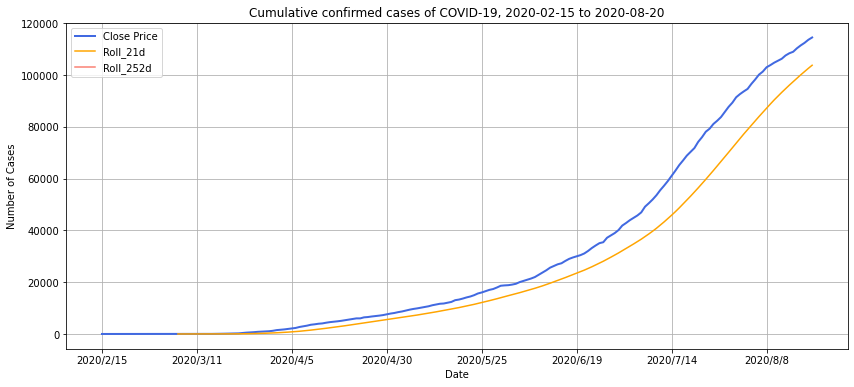

In [204]:
data_01['Alabama'].plot(lw=2., figsize=(14,6), label='Close Price',c='royalblue')
data_01['Alabama'].rolling(21).mean().plot(lw=1.5, label='Roll_21d',c='orange')
data_01['Alabama'].rolling(252).mean().plot(lw=1.5, label='Roll_252d', c='salmon')
plt.title('Cumulative confirmed cases of COVID-19, 2020-02-15 to 2020-08-20')
plt.ylabel('Number of Cases')
plt.grid(); plt.legend()

### 2.1 Imputation of missing value

In [96]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, BayesianRidge, LassoCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

In [205]:
data_01 = data_01.apply(pd.to_numeric)

data_01.isnull().values.any()

False

In [206]:
np.isinf(data_01).any()

Alabama                           False
retail                            False
grocery_and_pharmacy              False
parks                             False
transit_stations                  False
workplaces                        False
residential                       False
ICU_beds                          False
NEVER                             False
ALWAYS                            False
Number of Trips 1-10              False
Number of Trips 10-100            False
Number of Trips >100              False
Population Not Staying at Home    False
20_29                             False
prop over 60                      False
ConfirmedDeaths                   False
StringencyIndex                   False
GovernmentResponseIndex           False
ContainmentHealthIndex            False
EconomicSupportIndex              False
Annual income                     False
dtype: bool

In [207]:
data_01.columns

Index(['Alabama', 'retail', 'grocery_and_pharmacy', 'parks',
       'transit_stations', 'workplaces', 'residential', 'ICU_beds', 'NEVER',
       'ALWAYS', 'Number of Trips 1-10', 'Number of Trips 10-100',
       'Number of Trips >100', 'Population Not Staying at Home', '20_29',
       'prop over 60', 'ConfirmedDeaths', 'StringencyIndex',
       'GovernmentResponseIndex', 'ContainmentHealthIndex',
       'EconomicSupportIndex', 'Annual income'],
      dtype='object')

In [208]:
features = ['Alabama', 'retail', 'grocery_and_pharmacy', 'parks',
       'transit_stations', 'workplaces', 'residential', 'ICU_beds', 'NEVER',
       'ALWAYS', 'Number of Trips 1-10', 'Number of Trips 10-100',
       'Number of Trips >100', 'Population Not Staying at Home', '20_29',
       'prop over 60', 'ConfirmedDeaths', 'StringencyIndex',
       'GovernmentResponseIndex', 'ContainmentHealthIndex',
       'EconomicSupportIndex', 'Annual income']

In [209]:
data_01 = pd.DataFrame(data_01.replace([np.inf, -np.inf], np.nan))
data_01 = data_01.fillna(method='ffill')
data_01 = data_01.fillna(method='bfill')

In [210]:
data_01.isnull().values.any()

False

In [211]:
static_features = ['ICU_beds', 'NEVER','ALWAYS', '20_29', 'prop over 60', 'Annual income']
for i in static_features:
    data_01[i] = data_01[i].fillna(0)
    
static_data_01 = data_01[static_features]

In [212]:
continuous_features = [i for i in features if i not in static_features]
continuous_data_01 = data_01[continuous_features]

In [213]:
continuous_data_01

,Alabama,retail,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,Number of Trips 1-10,Number of Trips 10-100,Number of Trips >100,Population Not Staying at Home,ConfirmedDeaths,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex
Date,,,,,,,,,,,,,,,,
2020/2/15,0,5,2,39,7,2,-1,12757978,4038709,240285,4042364,0,5.56,8.89,10.26,0.0
2020/2/16,0,0,-2,-7,3,-1,1,11078888,3121356,242758,3917865,0,5.56,8.89,10.26,0.0
2020/2/17,0,3,0,17,7,-17,4,10242946,3370752,211760,3825630,0,5.56,8.89,10.26,0.0
2020/2/18,0,-4,-3,-11,-1,1,2,12158133,3983798,239611,4101268,0,5.56,8.89,10.26,0.0
2020/2/19,0,4,1,6,4,1,0,12926640,4113156,230278,4141135,0,5.56,8.89,10.26,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020/8/16,110361,-11,0,51,6,-17,3,9630832,3137638,299408,3867606,1898,46.30,51.11,53.21,37.5
2020/8/17,111478,-11,0,51,6,-29,6,10197214,3661304,267487,3931541,1925,46.30,51.11,53.21,37.5
2020/8/18,112449,-11,0,51,6,-27,7,9405104,3492009,281832,3913651,1936,46.30,51.11,53.21,37.5


In [128]:
data_01 = data_01[~data_01.isin([np.nan, np.inf, -np.inf]).any(1)]

In [97]:
brm = BayesianRidge(n_iter=1000)
imputer = IterativeImputer(estimator=brm, sample_posterior=True, max_iter=25)

In [98]:
fulldata = data_01.copy()
imputer = imputer.fit(fulldata)

In [99]:
fulldata = imputer.fit_transform(fulldata)

In [101]:
imputed_df = pd.DataFrame(fulldata)
imputed_df.columns = data_01.columns
imputed_df.index = data_01.index

In [256]:
data_01 = pd.read_csv("/Users/likehang/Desktop/data_01_cleaned.csv", index_col = False)
data_01 = data_01.set_index('Date')

In [257]:
data_01.drop(data_01.columns.difference(['Alabama','retail','grocery_and_pharmacy','parks', 'transit_stations', 'workplaces', 'residential','Number of Trips 1-10', 'Number of Trips 10-100',
       'Number of Trips >100', 'Population Not Staying at Home']), 1, inplace=True)

In [238]:
data_01

,Alabama,retail,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,Number of Trips 1-10,Number of Trips 10-100,Number of Trips >100,Population Not Staying at Home,ConfirmedDeaths,StringencyIndex,GovernmentResponseIndex,ContainmentHealthIndex,EconomicSupportIndex
Date,,,,,,,,,,,,,,,,
2020/2/15,0,5,2,39,7,2,-1,12757978,4038709,240285,4042364,0,5.56,8.89,10.26,0.0
2020/2/16,0,0,-2,-7,3,-1,1,11078888,3121356,242758,3917865,0,5.56,8.89,10.26,0.0
2020/2/17,0,3,0,17,7,-17,4,10242946,3370752,211760,3825630,0,5.56,8.89,10.26,0.0
2020/2/18,0,-4,-3,-11,-1,1,2,12158133,3983798,239611,4101268,0,5.56,8.89,10.26,0.0
2020/2/19,0,4,1,6,4,1,0,12926640,4113156,230278,4141135,0,5.56,8.89,10.26,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020/8/16,110361,-11,0,51,6,-17,3,9630832,3137638,299408,3867606,1898,46.30,51.11,53.21,37.5
2020/8/17,111478,-11,0,51,6,-29,6,10197214,3661304,267487,3931541,1925,46.30,51.11,53.21,37.5
2020/8/18,112449,-11,0,51,6,-27,7,9405104,3492009,281832,3913651,1936,46.30,51.11,53.21,37.5


/Users/likehang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/likehang/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    34743.98           5489549.0
Prediction (s.d.)         35.99 (1.09)       5687.02 (171.68)
95% CI                    [33.93, 38.19]     [5360.48, 6033.46]

Absolute effect (s.d.)    34707.99 (1.09)    5483861.98 (171.68)
95% CI                    [34705.79, 34710.05][5483515.54, 5484188.52]

Relative effect (s.d.)    96427.74% (3.02%)  96427.74% (3.02%)
95% CI                    [96421.65%, 96433.48%][96421.65%, 96433.48%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 34743.98. By contrast, in the absence of an
intervention, we would have expected an average response of 35.99.
The 95% interval of this counterfactual prediction is [33.93, 38.19].


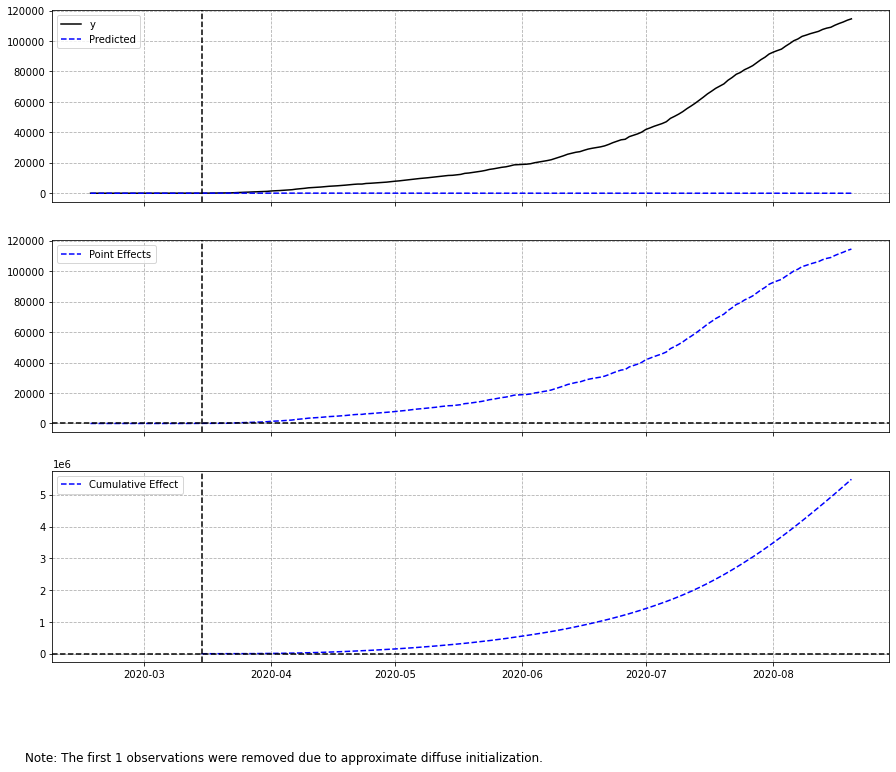

In [258]:
pre_period = ['2020-02-16', '2020-03-15']

post_period = ['2020-03-16', '2020-08-20'] 


ci = CausalImpact(data_01, pre_period, post_period)
print(ci.summary())
print(ci.summary(output='report'))
ci.plot()

In [259]:
ci.trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                Alabama   No. Observations:                   29
Model:                    local level   Log Likelihood                 -14.275
Date:                Thu, 11 Mar 2021   AIC                             52.549
Time:                        16:48:59   BIC                             68.536
Sample:                    02-16-2020   HQIC                            57.437
                         - 03-15-2020                                         
Covariance Type:                  opg                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
sigma2.irregular                        0.1431      0.083      1.724      0.085      -0.020       0.306
sigma2.level                            0.0001      0.007      0.020      0.984      -0.014       0.014
beta.retail                            -0.6813      0.363     -1.876      0.061      -1.393       0.031
beta.grocery_and_pharmacy               0.3462      0.250      1.387      0.166      -0.143       0.836
beta.parks                              0.3337      0.399      0.837      0.403      -0.448       1.115
beta.transit_stations                  -0.2784      0.253     -1.098      0.272      -0.775       0.218
beta.workplaces                        -0.0631      0.320     -0.197      0.844      -0.691       0.565
beta.residential                        0.0400      0.616      0.065      0.948      -1.168       1.248
beta.Number of Trips 1-10               0.9886      0.751      1.317      0.188      -0.482       2.460
beta.Number of Trips 10-100            -0.8142      0.721     -1.129      0.259      -2.227       0.599
beta.Number of Trips >100              -0.3576      0.194     -1.840      0.066      -0.739       0.023
beta.Population Not Staying at Home    -0.1926      0.577     -0.334      0.738      -1.323       0.938
===================================================================================
Ljung-Box (Q):                       34.63   Jarque-Bera (JB):                 0.07
Prob(Q):                              0.15   Prob(JB):                         0.97
Heteroskedasticity (H):               2.01   Skew:                            -0.10
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

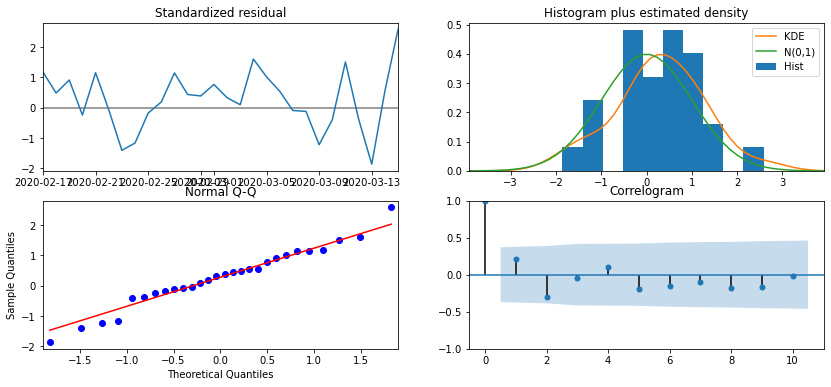

In [260]:
_ = ci.trained_model.plot_diagnostics(figsize=(14,6))